In [2]:
import pickle
import pandas as pd
import numpy as np
import cv2
import watermark
from matplotlib import pyplot as plt
import time
%matplotlib inline
import joblib
from skimage.measure import block_reduce



In [ ]:
#References
# 1. https://towardsdatascience.com/understanding-convolutions-and-pooling-in-neural-networks-a-simple-explanation-885a2d78f211
# 2. https://medium.com/@bdhuma/which-pooling-method-is-better-maxpooling-vs-minpooling-vs-average-pooling-95fb03f45a9
# 3. https://towardsdatascience.com/region-of-interest-pooling-f7c637f409af
# 4. https://www.ml-science.com/pooling
# 5. 


In [3]:
#An implementation of pooling would basically look at cross sections and store the max pixel value in each cross section.
    # If we wanted to get a 5x5 version of the image, we would look at unique 2x2 cross sections of the image and store
    # max pixel values of each cross section

#NEIL: I had to re-run standardize_image_dataset locally to get labeled_data.pkl to work
# Cancer536.jpg seems to be the first one in your examples
    
scan_path = "/Users/neilbhatia/GitHub/w207_final_project/Amit/Labeled Data/labeled_data.pkl"

In [4]:
# Generic version of pooling function
    # function that allows you to pass in the image vector, 
    # define a cross section size, 
    # and a pooling function (max, min, mean, etc). 
    # Then it would return a modified version of the image that contains a pooled value for each cross section of the image.


In [5]:
brain_scans = pickle.load(open(scan_path,'rb'))

In [6]:
#Using 192 since my local images are out of order and we were using this for the presentation
original_img = brain_scans.iloc[192,:-1].to_numpy().reshape(150, 150)


In [7]:
brain_scans.iloc[1,:-1].to_numpy().reshape(150, 150)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

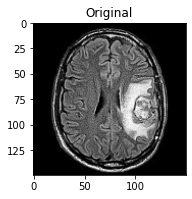

In [8]:

original_img = brain_scans.iloc[192,:-1].to_numpy().reshape(150, 150)

plt.subplot(121),plt.imshow(original_img, cmap='gray'),plt.title('Original')
plt.show()

In [9]:
# Pooling function 1 - using block_size

def do_pooling(image, pool_size = (2,2), pooling_function = np.max):
    """This function takes an image pixel matrix and, given a pool size
    and pooling function, returns a pooled version of that image"""
    
    if pooling_function in [np.mean,np.max,np.min]:
        return block_reduce(image, block_size=pool_size, func = pooling_function) 
    else:
        raise Exception("Please specify a pooling function, either np.mean, np.max, or np.min.")
    
    # max_pool=block_reduce(img, block_size=(9,9,1), func=np.max)
    # min_pool=block_reduce(img, block_size=(9,9,1), func=np.min)


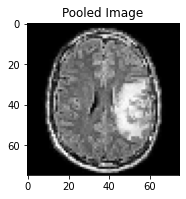

In [10]:
pooled_image =  do_pooling(original_img,pool_size=(2,2),pooling_function=np.max)
plt.subplot(121),plt.imshow(pooled_image, cmap='gray'),plt.title('Pooled Image')
plt.show()

In [11]:
%%timeit
pooled_image =  do_pooling(original_img,pool_size=(2,2),pooling_function=np.max)

1.95 ms ± 252 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


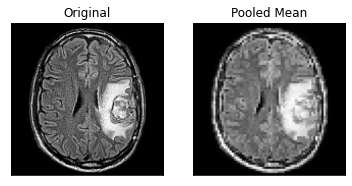

In [12]:
# Pooling function 2 - 
# https://towardsdatascience.com/understanding-convolutions-and-pooling-in-neural-networks-a-simple-explanation-885a2d78f211
# https://github.com/miguelfzafra/Convolutional-Neural-Networks/blob/master/CNN_convolutions_and_pooling.ipynb\


# naive filter AKA no filter
no_filter = \
           [[+0.0, +0.0, +0.0], 
            [+0.0, +1.0, +0.0], 
            [+0.0, +0.0, +0.0]]

# filter for detecting vertical lines
filter_vertical = \
           [[+1.0, +0.0, -1.0], 
            [+1.0, +0.0, -1.0], 
            [+1.0, +0.0, -1.0]]

# filter for detecting horizontal lines
filter_horizontal = \
           [[+1.0, +1.0, +1.0], 
            [+0.0, +0.0, +0.0], 
            [-1.0, -1.0, -1.0]]


# filter for detecting obliquous lines
filter_obliquous = \
           [[-1.0, -1.0, +2.0], 
            [-1.0, +2.0, -1.0], 
            [+2.0, -1.0, -1.0]]

# filter for getting blurry images
filter_blur = \
           [[+1.0, +1.0, +1.0], 
            [+1.0, +1.0, +1.0], 
            [+1.0, +1.0, +1.0]]

# filter for getting sharper edges
filter_edges = \
           [[+1.0, +1.0, +1.0], 
            [+1.0, -7.0, +1.0], 
            [+1.0, +1.0, +1.0]]


def do_pooling2(image,pool_size=(2,2), filter = no_filter, pooling_function = np.max):
  if pooling_function in [np.mean,np.max,np.min]:
    i_transformed = np.copy(image)
    size_x = i_transformed.shape[0]
    size_y = i_transformed.shape[1]

    if np.sum(filter) == 0:
      weight = 1.
    else:
      weight = 1 / np.sum(filter)

    for x in range(1,size_x-1):
      for y in range(1,size_y-1):
          convolution = 0.0
          convolution = convolution + (image[x-1, y-1] * filter[0][0])
          convolution = convolution + (image[x-1, y] * filter[0][1])
          convolution = convolution + (image[x-1, y+1] * filter[0][2])
          convolution = convolution + (image[x, y-1] * filter[1][0])
          convolution = convolution + (image[x, y] * filter[1][1])
          convolution = convolution + (image[x, y+1] * filter[1][2])
          convolution = convolution + (image[x+1, y-1] * filter[2][0])
          convolution = convolution + (image[x+1, y] * filter[2][1])
          convolution = convolution + (image[x+1, y+1] * filter[2][2])
          convolution = convolution * weight
          if(convolution<0):
            convolution=0
          if(convolution>255):
            convolution=255
          i_transformed[x, y] = convolution
          
    new_x = int(size_x/pool_size[0])
    new_y = int(size_y/pool_size[1])

    newImage = np.zeros((new_x, new_y))
    for x in range(0, size_x, pool_size[0]):
      for y in range(0, size_y, pool_size[1]):
        pixels = []
        pixels.append(i_transformed[x, y])
        pixels.append(i_transformed[x+1, y])
        pixels.append(i_transformed[x, y+1])
        pixels.append(i_transformed[x+1, y+1])
        if pooling_function == np.max:
          newImage[int(x/pool_size[0]),int(y/pool_size[1])] = np.max(pixels)  # try with average
        elif pooling_function == np.min:
          newImage[int(x/pool_size[0]),int(y/pool_size[1])] = np.min(pixels)
        elif pooling_function == np.mean:
          newImage[int(x/pool_size[0]),int(y/pool_size[1])] = np.mean(pixels)
          
    return newImage
  else:
    raise Exception("Please specify a pooling function, either np.mean, np.max, or np.min.")
  
  

pooled_image2 = do_pooling2(image = original_img,pool_size = (2,2), filter = no_filter,pooling_function = np.max)

plt.subplot(121),plt.imshow(original_img, cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(pooled_image2, cmap='gray'),plt.title('Pooled Mean')
plt.xticks([]), plt.yticks([])
plt.show()
  

In [13]:
%%timeit
pooled_image2 = do_pooling2(image = original_img,pool_size = (2,2), filter = no_filter,pooling_function = np.max)

433 ms ± 51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Pooling Function 1 - SK Image "block_reduce", 2x2 pool size

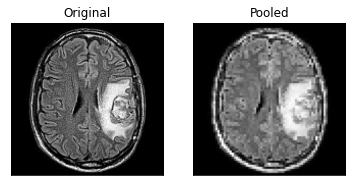

In [15]:
# Implementing Pooling Function 1
original_img
pooled_image
plt.subplot(121),plt.imshow(original_img, cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(pooled_image, cmap='gray'),plt.title('Pooled')
plt.xticks([]), plt.yticks([])
plt.show()

NameError: name 'ax' is not defined

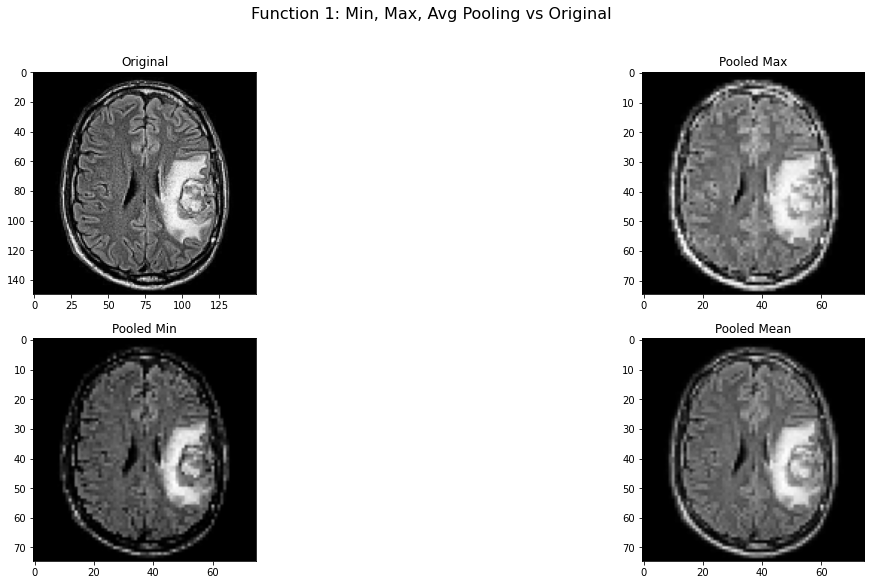

In [19]:
#Looping across mean, min, avg

# Implementing Pooling Function 1
original_img
pooled_image

figure, axis = plt.subplots(2, 2,figsize=(20,9))
figure.suptitle("Function 1: Min, Max, Avg Pooling vs Original", fontsize=16)

axis[0,0].imshow(original_img, cmap='gray')
axis[0,0].set_title("Original")

axis[0,1].imshow(do_pooling(original_img,pool_size=(2,2),pooling_function=np.max), cmap='gray')
axis[0,1].set_title("Pooled Max")

axis[1,0].imshow(do_pooling(original_img,pool_size=(2,2),pooling_function=np.min), cmap='gray')
axis[1,0].set_title("Pooled Min")

axis[1,1].imshow(do_pooling(original_img,pool_size=(2,2),pooling_function=np.mean), cmap='gray')
axis[1,1].set_title("Pooled Mean")


plt.show()
# figure.savefig('pooling_images.png')





# Pooling Function 2 - Custom, 2x2 pool size

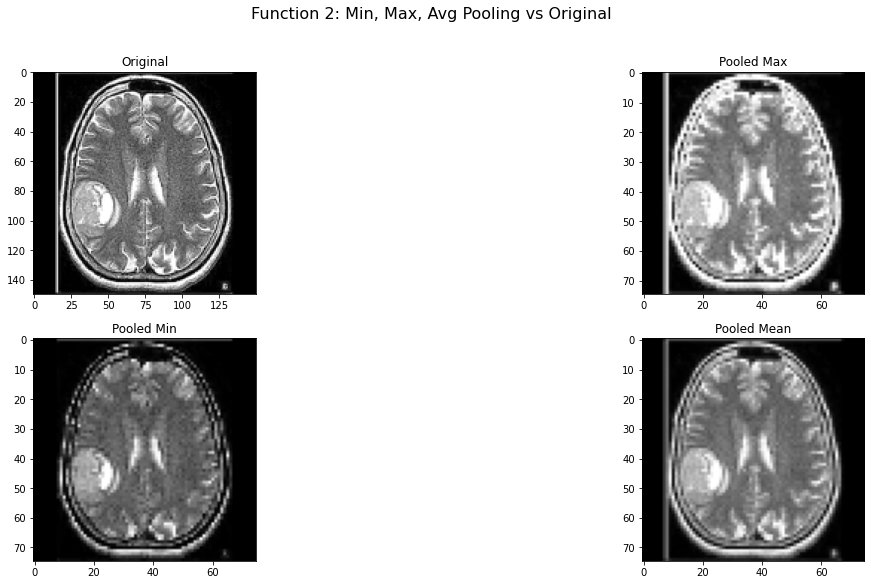

In [155]:
#Looping across mean, min, avg

original_img
pooled_image

figure, axis = plt.subplots(2, 2,figsize=(20,9))
figure.suptitle("Function 2: Min, Max, Avg Pooling vs Original", fontsize=16)

axis[0,0].imshow(original_img, cmap='gray')
axis[0,0].set_title("Original")

axis[0,1].imshow(do_pooling2(original_img,pool_size=(2,2),pooling_function=np.max), cmap='gray')
axis[0,1].set_title("Pooled Max")

axis[1,0].imshow(do_pooling2(original_img,pool_size=(2,2),pooling_function=np.min), cmap='gray')
axis[1,0].set_title("Pooled Min")

axis[1,1].imshow(do_pooling2(original_img,pool_size=(2,2),pooling_function=np.mean), cmap='gray')
axis[1,1].set_title("Pooled Mean")

plt.show()




# Saving function 1 outputs for presentation

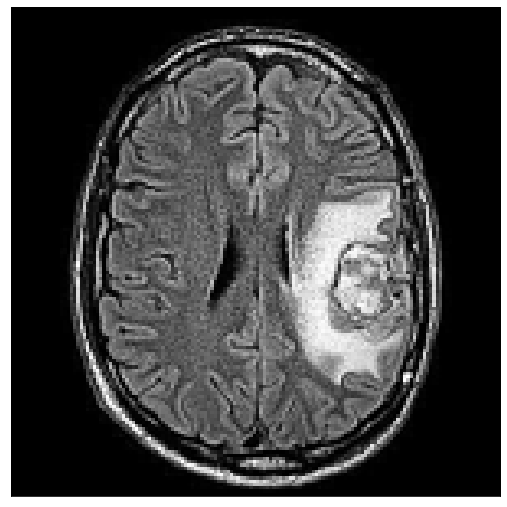

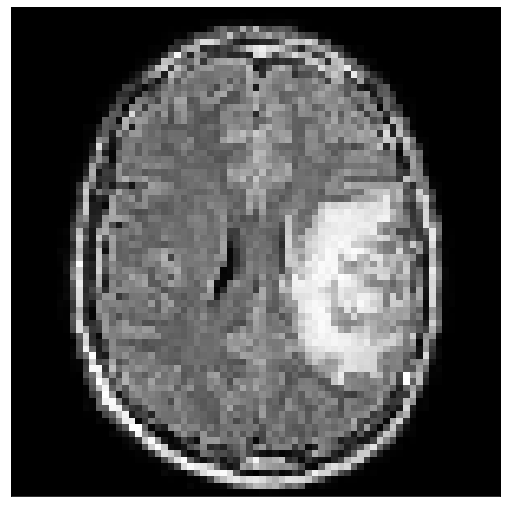

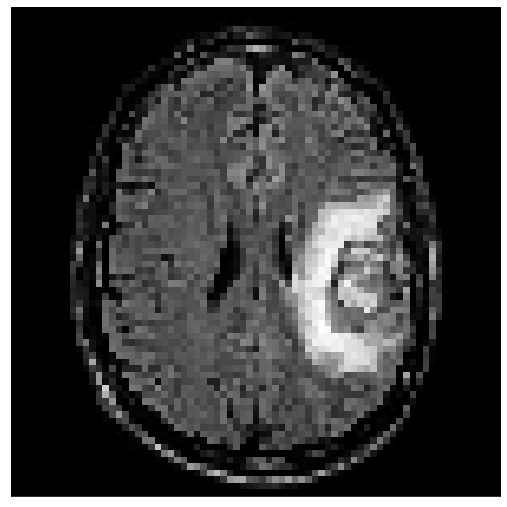

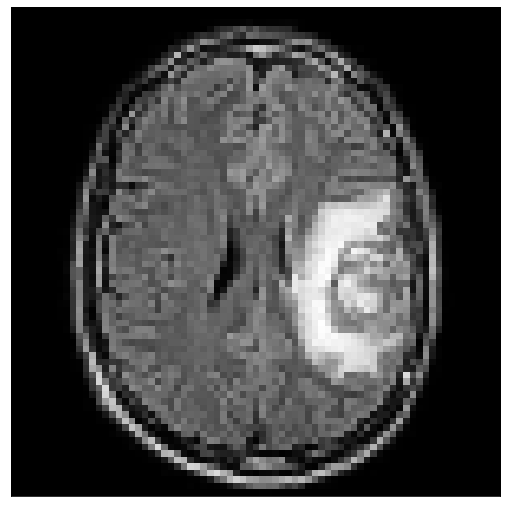

In [32]:
#Looping across mean, min, avg

# Implementing Pooling Function 1
original_img
pooled_image


# figure.suptitle("Function 1: Min, Max, Avg Pooling vs Original", fontsize=16)

# axis[0,0].imshow(original_img, cmap='gray')
# axis[0,0].set_title("Original")
# axis[0,0].set_xticks([])
# axis[0,0].set_yticks([])
figure, axis = plt.subplots(1, 1,figsize=(20,9))
axis.imshow(original_img,cmap='gray')
axis.set_xticks([]) 
axis.set_yticks([])
figure.savefig('pooling_images/pooling_original.png')


figure, axis = plt.subplots(1, 1,figsize=(20,9))
axis.imshow(do_pooling(original_img,pool_size=(2,2),pooling_function=np.max), cmap='gray')
axis.set_xticks([]) 
axis.set_yticks([])
figure.savefig('pooling_images/pooling_max.png')


figure, axis = plt.subplots(1, 1,figsize=(20,9))
axis.imshow(do_pooling(original_img,pool_size=(2,2),pooling_function=np.min), cmap='gray')
axis.set_xticks([]) 
axis.set_yticks([])
figure.savefig('pooling_images/pooling_min.png')


figure, axis = plt.subplots(1, 1,figsize=(20,9))
axis.imshow(do_pooling(original_img,pool_size=(2,2),pooling_function=np.mean), cmap='gray')
axis.set_xticks([]) 
axis.set_yticks([])
figure.savefig('pooling_images/pooling_mean.png')

# axis[0,1].imshow(do_pooling(original_img,pool_size=(2,2),pooling_function=np.max), cmap='gray')
# axis[0,1].set_title("Pooled Max")
# axis[0,1].set_xticks([])
# axis[0,1].set_yticks([])

# axis[1,0].imshow(do_pooling(original_img,pool_size=(2,2),pooling_function=np.min), cmap='gray')
# axis[1,0].set_title("Pooled Min")
# axis[1,0].set_xticks([])
# axis[1,0].set_yticks([])

# axis[1,1].imshow(do_pooling(original_img,pool_size=(2,2),pooling_function=np.mean), cmap='gray')
# axis[1,1].set_title("Pooled Mean")
# axis[1,1].set_xticks([])
# axis[1,1].set_yticks([])


plt.show()
# figure.savefig('pooling_images.png')





In [33]:
help(block_reduce)

Help on function block_reduce in module skimage.measure.block:

block_reduce(image, block_size, func=<function sum at 0x1126905e0>, cval=0, func_kwargs=None)
    Downsample image by applying function `func` to local blocks.
    
    This function is useful for max and mean pooling, for example.
    
    Parameters
    ----------
    image : ndarray
        N-dimensional input image.
    block_size : array_like
        Array containing down-sampling integer factor along each axis.
    func : callable
        Function object which is used to calculate the return value for each
        local block. This function must implement an ``axis`` parameter.
        Primary functions are ``numpy.sum``, ``numpy.min``, ``numpy.max``,
        ``numpy.mean`` and ``numpy.median``.  See also `func_kwargs`.
    cval : float
        Constant padding value if image is not perfectly divisible by the
        block size.
    func_kwargs : dict
        Keyword arguments passed to `func`. Notably useful for pas

In [ ]:
def do_pooling_dataset(image_dataset, pool_size = (2,2), pooling_function = np.max):
    pooled_images = image_dataset.copy()
    for num in range(len(pooled_images)):
        image_reshaped = pooled_images.iloc[num].to_numpy().reshape(150,150)                         
        pooled_images.iloc[num] = do_pooling(image_reshaped,pool_size,pooling_function).flatten()
    return pooled_images